<a href="https://colab.research.google.com/github/Muzzamal-Hameed/Deep-Learning-Models/blob/main/tennis_ball_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d domhenjes/ballsemtpytt

 99% 193M/195M [00:05<00:00, 30.5MB/s]
100% 195M/195M [00:05<00:00, 40.2MB/s]


In [7]:
! unzip ballsemtpytt.zip

Archive:  ballsemtpytt.zip
  inflating: emptyballs/test/balls/ball100.jpg  
  inflating: emptyballs/test/balls/ball116.jpg  
  inflating: emptyballs/test/balls/ball118.jpg  
  inflating: emptyballs/test/balls/ball129.jpg  
  inflating: emptyballs/test/balls/ball152.jpg  
  inflating: emptyballs/test/balls/ball166.jpg  
  inflating: emptyballs/test/balls/ball169.jpg  
  inflating: emptyballs/test/balls/ball187.jpg  
  inflating: emptyballs/test/balls/ball19.jpg  
  inflating: emptyballs/test/balls/ball194.jpg  
  inflating: emptyballs/test/balls/ball200.jpg  
  inflating: emptyballs/test/balls/ball203.jpg  
  inflating: emptyballs/test/balls/ball21.jpg  
  inflating: emptyballs/test/balls/ball232.jpg  
  inflating: emptyballs/test/balls/ball300.jpg  
  inflating: emptyballs/test/balls/ball301.jpg  
  inflating: emptyballs/test/balls/ball324.jpg  
  inflating: emptyballs/test/balls/ball327.jpg  
  inflating: emptyballs/test/balls/ball328.jpg  
  inflating: emptyballs/test/balls/ball342.j

In [10]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from time import time
from PIL import ImageDraw
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom

from keras import backend as K
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [11]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [12]:
augs = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True,
    validation_split=0.3)  

train_gen = augs.flow_from_directory(
    '/content/emptyballs/train/',
    target_size = (150,150),
    batch_size=8,
    class_mode = 'binary')

test_gen = augs.flow_from_directory(
    '/content/emptyballs/test/',
    target_size=(150,150),
    batch_size=8,
    class_mode='binary',
    subset='validation')

Found 823 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


58900480/58889256 [==============================] - 0s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f94b5370c50> False
<keras.layers.convolutional.Conv2D object at 0x7f94b22ca710> False
<keras.layers.convolutional.Conv2D object at 0x7f94afdc5390> False
<keras.layers.pooling.MaxPooling2D object at 0x7f94afd94890> False
<keras.layers.convolutional.Conv2D object at 0x7f94afd55250> False
<keras.layers.convolutional.Conv2D object at 0x7f94b22c2f90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f94afd5b7d0> False
<keras.layers.convolutional.Conv2D object at 0x7f94afd63850> True
<keras.layers.convolutional.Conv2D object at 0x7f94afd6b950> True
<keras.layers.convolutional.Conv2D object at 0x7f94afd75b90> True
<keras.layers.pooling.MaxPooling2D object at 0x7f94b4643110> True
<keras.layers.convolutional.Conv2D object at 0x7f94afd74310> True
<keras.layers.convolutional.Conv2D object at 0x7f94afe04a90> True
<keras.layers.convolutional.Conv2D object at 0x7f94afcfd210> True
<k

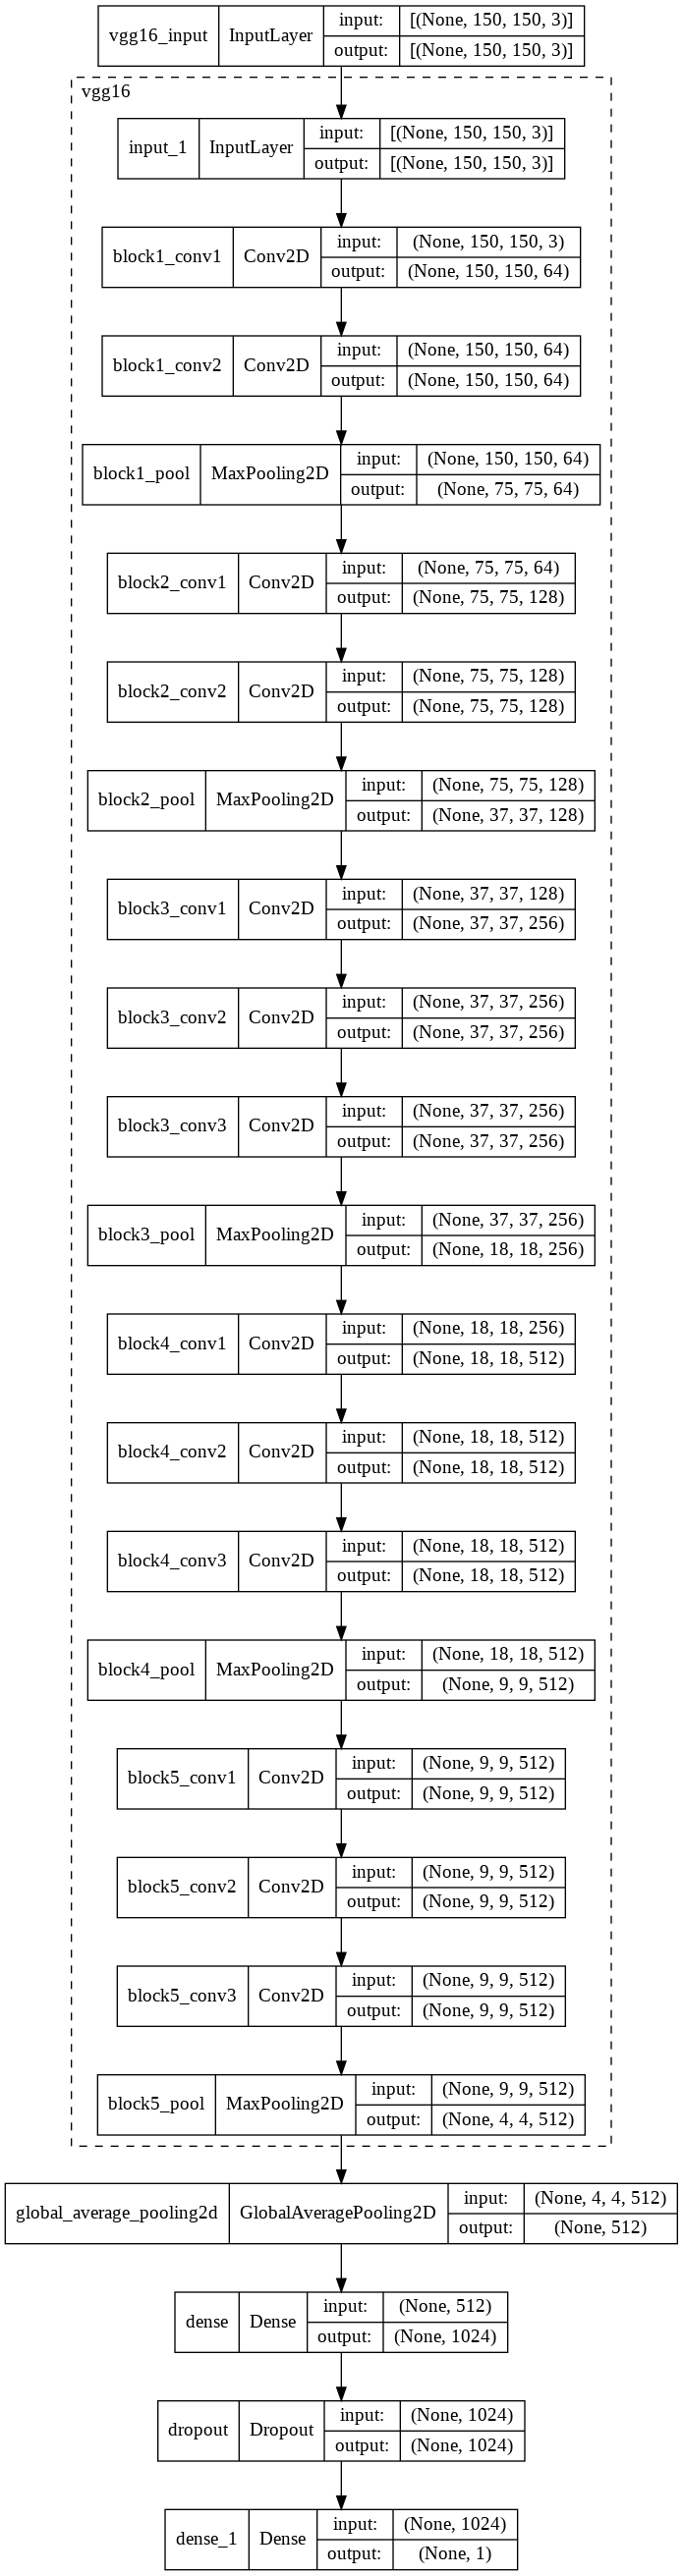

In [13]:
base_model = VGG16(include_top=False,
                  input_shape = (150,150,3),
                  weights = 'imagenet')

for layer in base_model.layers[:-12]:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [20]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [21]:
import tensorflow as tf

opt = tf.keras.optimizers.SGD(lr=1e-5,momentum=0.95)
opt1 = tf.keras.optimizers.Adam(lr=1e-4)


model.compile(
    loss='binary_crossentropy',
    optimizer=opt1,
    metrics=['accuracy']
)
    
history = model.fit_generator(
                    train_gen, 
                    steps_per_epoch  = 150, 
                    validation_data  = test_gen,
                    validation_steps = 150,
                    epochs           = 30, 
                    verbose          = 1,
    callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
103/150 [===================>..........] - ETA: 2:43 - loss: 0.4176 - accuracy: 0.7934WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 4500 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss improved from inf to 0.20304, saving model to ./base.model
INFO:tensorflow:Assets written to: ./base.model/assets
150/150 [==============================] - 367s 2s/step - loss: 0.4176 - accuracy: 0.7934 - val_loss: 0.2030 - val_accuracy: 0.8750 - lr: 1.0000e-04


In [ ]:
predictions = np.rint(model.predict(x_test))

In [22]:
print( classification_report(y_test, predictions) )

NameError: ignored

In [23]:
# show_final_history(history)
model.load_weights('./base.model')
model_score = model.evaluate_generator(test_gen)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model_tennis.h5")
print("Weights Saved")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Model Test Loss: 0.15007935464382172
Model Test Accuracy: 0.9166666865348816
Weights Saved


In [24]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './logs' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8080 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8080 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2022-01-05 06:38:00--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.161.241.46, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.19M  3.38MB/s    in 6.7s    

2022-01-05 06:38:07 (1.97 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: ngrok                   
https://5336-34-91-44-196.ngrok.io
